## Reverse image search and retrieval

This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images. Specifically, it will show you how you can retrieve a set of images which are similar to a query image, returning you its `n` nearest neighbors in terms of image content.

### Installation and dependencies

The code has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)
 * [cPickle](https://docs.python.org/2/library/pickle.html)

### Prepare dataset

Finally, prepare a folder of images to do the analysis on. If you don't have one, you may download and extract the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. To download that dataset, run the following commands inside a folder of your choosing (this notebook will assume you do so in the `data` folder of `ml4a-guides`.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
Or you can run the `download.sh` script in the `data` folder which will automatically download this dataset for you, along with all the other materials for these notebooks.

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [1]:
#!pip install tqdm

In [1]:
%matplotlib inline
import os
import random
#import cPickle as pickle
import pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
#import keras
#from keras.preprocessing import image
#from keras.applications.imagenet_utils import decode_predictions, preprocess_input
#from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

#from IPython.display import display 
#from PIL import Image
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

In [2]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We load an image into memory, convert it into an input vector, and see the model's top 5 predictions for it.

Once that is done, we will take our `n`x4096 matrix of features (where `n` is the number of images), and apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to it, and keep the first 300 principal components, creating an `n`x300 matrix called `pca_features`. 

The purpose of principal component analysis is to reduce the dimensionality of our feature vectors. This reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up. 



Let's do a query. What we'll do is define a function which returns the num_results closest images to a query image, with repsect to those images contents. What it dos is: for the given query image, it will take its PCA-activations, and compute the euclidean distance between it and every other set of PCA-activations, then return the best ones.
We also define a helper function get_concatenated_images which creates a thumbnail of a set of images, so we can display the results.

In [3]:
#path = '/home/kangeunsu/facenet/embeddings_from_genCeleb_2ksample_noflips.p'
#directory = "/home/kangeunsu/CelebAHQ_generated_images/celeba_gen_2k_sample/"

path = '/home/kangeunsu/facenet/embeddings_from_DCGAN_generated_300kImgs.p'
directory = "/home/kangeunsu/other_gans/DCGAN-tensorflow/samples_300k_generated/" 

to_load = 5000

full_features = pickle.load(open(path, 'rb'), encoding='latin1')
full_features = full_features[0]
full_features_n = np.asarray(full_features)
print("full_features_n.shape",full_features_n.shape)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=300)
#pca.fit(full_features_n)
#pca_features_mine = pca.transform(full_features_n)
#pca_features_mine_n = np.asarray(pca_features_mine)
#print("pca_features_mine_n.shape",pca_features_mine_n.shape)

pca_features_mine = full_features

import fnmatch
# files like img00009982.png
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths[0:to_load] # or full?
images_mine_n = np.asarray(images_mine)
print("images_mine_n.shape",images_mine_n.shape)

images_GEN = images_mine
pca_features_GEN = pca_features_mine[0:to_load]

full_features_n.shape (300000, 512)
images_mine_n.shape (5000,)


In [5]:
path = '/home/kangeunsu/facenet/embeddings_from_celebA_dataset_features.p'
directory = "/home/kangeunsu/other_gans/DCGAN-tensorflow/data/celebA/"

# these are original files from celebA (except that they have been processed by the DCGAN preprocess fcn)
# /home/kangeunsu/other_gans/DCGAN-tensorflow/samples/initsamples/ <- all
# just 10k
path = '/home/kangeunsu/facenet/embeddings_celebA_CroppedByDCGAN_first10k.p'
directory = "/home/kangeunsu/other_gans/DCGAN-tensorflow/first_10k_editedCelebA/"


to_load = 10000

full_features = pickle.load(open(path, 'rb'), encoding='latin1')
full_features = full_features[0]
full_features_n = np.asarray(full_features)
print("full_features_n.shape",full_features_n.shape)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=300)
#pca.fit(full_features_n)
#pca_features_mine = pca.transform(full_features_n)
#pca_features_mine_n = np.asarray(pca_features_mine)
#print("pca_features_mine_n.shape",pca_features_mine_n.shape)
pca_features_mine = full_features

import fnmatch
# files like img00009982.png
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths[0:to_load] # or full?
images_mine_n = np.asarray(images_mine)
print("images_mine_n.shape",images_mine_n.shape)

images_ORIG = images_mine
pca_features_ORIG = pca_features_mine[0:to_load]

full_features_n.shape (10000, 512)
images_mine_n.shape (10000,)


We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Thus we can define a new function `get_closest_images`, which will compute the euclidean distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [6]:
from PIL import Image as pil_image
def load_img(path, grayscale=False, target_size=None,
             interpolation='nearest'):
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            if interpolation not in _PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(
                        interpolation,
                        ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
            resample = _PIL_INTERPOLATION_METHODS[interpolation]
            img = img.resize(width_height_tuple, resample)
    return img

In [7]:
def get_closest_images(query_image_idx, num_results, pca_features_Query, pca_features_Dataset):
    distances = [ distance.euclidean(pca_features_Query[query_image_idx], feat) for feat in pca_features_Dataset ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height, images_Query):
    thumbs = []
    for idx in indexes:
        img = load_img(images_Query[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


Finally we can do a query on a randomly selected image in our dataset.

Random image from Generated => Closest NN from Original


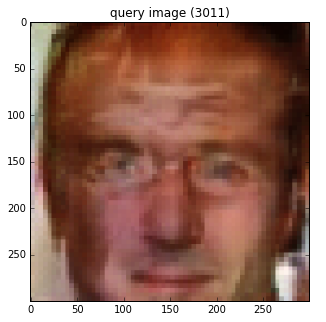

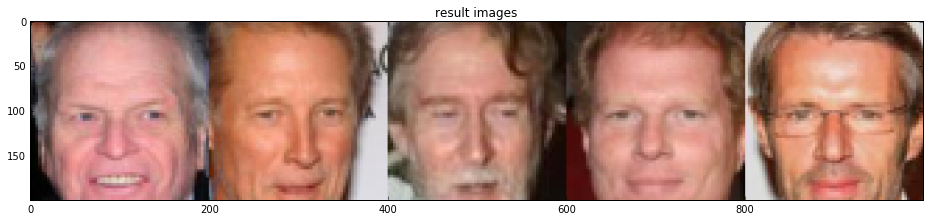

In [9]:
print("Random image from Generated => Closest NN from Original")
random_from = [images_GEN, pca_features_GEN]
closest_from = [images_ORIG, pca_features_ORIG]

#print("Random image from Original => Closest NN from Generated")
#random_from = [images_ORIG, pca_features_ORIG]
#closest_from = [images_GEN, pca_features_GEN]

# do a query on a random image
query_image_idx = int(len(images_GEN) * random.random())
idx_closest = get_closest_images(query_image_idx, 5, random_from[1], closest_from[1])
query_image = get_concatenated_images([query_image_idx], 300, random_from[0])
results_image = get_concatenated_images(idx_closest, 200, closest_from[0])

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

If we are satisfied with the quality of our image vectors, now would be a good time to save them to disk for later usage. You will need these vectors to run the [next notebook on making an image t-SNE](image-tsne.ipynb).

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. 

In [15]:
# not needed anymore pickle.dump([images, pca_features], open('./results/features_caltech101.p', 'wb'))